In [1]:
import time
import abc
import logging
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from numpy import ndarray
from typing import Any
from numpy import ndarray
from functools import wraps
from math import tan
from threading import Thread
from typing import Any


def timeit(fn):
    """计算函数运行时间的装饰器"""
    @wraps(fn)
    def measure_time(*args, **kwargs):
        t1 = time.time()
        result = fn(*args, **kwargs)
        t2 = time.time()
        print(f"@timeit: {fn.__name__} took {t2 - t1: .5f} s")
        return result
    return measure_time

class BaseImageProcess(metaclass=abc.ABCMeta):
    @timeit
    @abc.abstractmethod
    def process_image(self, image: ndarray) -> (ndarray, Any):
        """
        :param image: 读入的图片
        :return: 第一个返回值是处理后的图片，第二个返回值是额外的信息，包括异常的位置、轮廓(如果有)等信息
        """
        pass

def calculate_distance(point1, point2):
    """
    计算两点之间的距离
    :param point1:
    :param point2:
    :return:
    """
    return ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) ** 0.5

In [2]:

def process_feature_points(image, template, keypoints1, keypoints2, matches):
    def get_match_points(keypoints, matches):
        match_points = []
        for match in matches:
            match_points.append(keypoints[match.queryIdx])
        return match_points

    match_points = get_match_points(keypoints1, matches)
    cv2.drawKeypoints(image, match_points, image, color=[0, 255, 0])

    def find_avg_points(points):
        avgx = avgy = 0
        for point in points:
            avgx += point.pt[0]
            avgy += point.pt[1]
        avgx /= len(points)
        avgy /= len(points)
        return int(avgx), int(avgy)

    avg = find_avg_points(match_points)
    cv2.circle(image, avg, 5, (0, 0, 255), 2)

    # imwrite('keypoints_sift.png', image)

    def cal_dispersion(match_points_list, avg_point):
        """
        计算点的离散程度
        :param match_points_list:
        :return:
        """
        distance_list = []
        new_points_list = []
        for point in match_points_list:
            distance = calculate_distance(point.pt, avg_point)
            distance_list.append(distance)
            if distance <= 130:
                new_points_list.append(point)
        return sum(distance_list) / len(match_points_list), new_points_list

    dispersion, new_points_list = cal_dispersion(match_points, avg)
    if dispersion > 140:
        # logging.info("模板不太行")
        # 这个阈值需要调整
        # 走到这里代表模板不太行，换一个
        return False
    else:
        return dispersion, new_points_list
        # cv2.drawKeypoints(image2, new_points_list, image2, color=[0, 255, 0])


def SIFT(image, template):
    sift = cv2.SIFT_create()
    # template = self.templates[0]
    kp1, des1 = sift.detectAndCompute(image, None)
    kp2, des2 = sift.detectAndCompute(template, None)
    # 暴力匹配BFMatcher，遍历描述符，确定描述符是否匹配，然后计算匹配距离并排序
    # BFMatcher函数参数：
    # normType：NORM_L1, NORM_L2, NORM_HAMMING, NORM_HAMMING2。
    # NORM_L1和NORM_L2是SIFT和SURF描述符的优先选择，NORM_HAMMING和NORM_HAMMING2是用于ORB算法
    bf = cv2.BFMatcher(normType=cv2.NORM_L1, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    # matches是DMatch对象，具有以下属性：
    # DMatch.distance - 描述符之间的距离。 越低越好。
    # DMatch.trainIdx - 训练描述符中描述符的索引
    # DMatch.queryIdx - 查询描述符中描述符的索引
    # DMatch.imgIdx - 训练图像的索引。

    # 使用plt将两个图像的匹配结果显示出来
    # img3 = cv2.drawMatches(img1=image, keypoints1=kp1, img2=template, keypoints2=kp2, matches1to2=matches,
    #                        outImg=template,
    #                        flags=2)

    # plt.imshow(img3), plt.show()
    return image, template, kp1, kp2, matches


def calculate_dispersion(image, template):
    res = SIFT(image.copy(), template)
    out = process_feature_points(*res)
    return out


class CalculateDispersionThread(Thread):
    def __init__(self, image, template):
        super().__init__()
        self.image = image
        self.template = template
        self.res = None

    def run(self):
        self.res = calculate_dispersion(self.image, self.template)

    def get_out(self):
        return self.res


class PressureLocationProcess(BaseImageProcess):

    def __init__(self, templates_dir):

        self.templates = [cv2.imread(os.path.join(templates_dir, i), cv2.IMREAD_UNCHANGED) for i in
                          os.listdir(templates_dir)]
        self.distance1 = 0
        self.distance2 = 0

    def cut_image(self, image: ndarray) -> (ndarray, ndarray, tuple):
        """
        输入一张图片，切割出压线筒区域，返回切割后的图片和边缘的坐标
        :param image:
        :return:
        """
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        lower_blue = np.array([100, 43, 46])
        upper_blue = np.array([124, 255, 255])
        mask = cv2.inRange(hsv, lower_blue, upper_blue)
        img_morph = mask.copy()
        core = (3, 3)
        cv2.erode(img_morph, core, img_morph, iterations=2)
        cv2.dilate(img_morph, core, img_morph, iterations=2)
        # 中值滤波
        img_morph = cv2.medianBlur(img_morph, 15)
        # 获取面积最大的轮廓 ，这个轮廓是除了物体的区域
        res = cv2.findContours(img_morph, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        cnts = res[0]
        cnts_sort = sorted(cnts, key=cv2.contourArea, reverse=True)
        # 搞一个白底的图，然后把轮廓区域填充黑色
        white_image = np.zeros(image.shape, np.uint8)
        white_image[:, :, :] = 255
        cv2.drawContours(white_image, cnts_sort, 0, (0, 0, 0), -1)
        white_image = cv2.cvtColor(white_image, cv2.COLOR_BGR2GRAY)
        object_edge = cv2.findContours(white_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        img_copy = image.copy()
        # 用绿色圈出轮廓
        cv2.drawContours(img_copy, object_edge[0][0], -1, (0, 255, 0), 10)
        # imwrite('img_green_edge.png', img_copy)
        image = self.fill_outside_black(image, object_edge[0][0])
        # 用方框裁出来
        x, y, w, h = cv2.boundingRect(object_edge[0][0])
        pure_img = image.copy()
        # 获得方框
        cv2.rectangle(pure_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # imwrite('pure_img.png', pure_img)
        # 裁剪
        cuted_image = image[y:y + h, x:x + w]
        # imwrite('cuted_image.png', cuted_image)
        bounding = res[0][0]

        # 裁剪后边缘需要移动到图片上
        def bounding_move(bounding_point):
            bounding_point[0, 0] -= x
            bounding_point[0, 1] -= y
            return bounding_point

        bounding = np.array(list(map(bounding_move, bounding)))
        return cuted_image, bounding, (x, y)

    def cut_cone(self, image: ndarray):
        """

        TODO 这个函数被cut_cone_v2替代
        把线芯给去掉
        TODO 这里的参数还是得调整，这里会把露出的线芯也包含进去
        :param image:
        :return:
        """
        OLD_IMG = image.copy()

        # imwrite('old_img.png', OLD_IMG)
        gray_old_img = cv2.cvtColor(OLD_IMG, cv2.COLOR_BGR2GRAY)
        # imwrite('gray_old_img.png', gray_old_img)
        # TODO 这里的参数要调整
        high_brightness = self.change_brightness_and_contrast(gray_old_img, 0, 250)
        # imwrite('high_brightness.png', high_brightness)
        # TODO 这里的参数要调整
        ret, thresh1 = cv2.threshold(high_brightness, 120, 255, cv2.THRESH_BINARY)
        # imwrite('thresh1.png', thresh1)
        core = (3, 3)
        cv2.erode(thresh1, (2, 2), thresh1, iterations=10)
        # imwrite('erode.png', thresh1)
        cv2.dilate(thresh1, (4, 4), thresh1, iterations=25)
        # imwrite('dilate.png', thresh1)
        res = cv2.findContours(thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        cnts_sort = sorted(res[0], key=cv2.contourArea, reverse=True)
        # cnts_sort[0] 就是线材的边缘
        cv2.drawContours(OLD_IMG, cnts_sort, 0, (0, 0, 255), -1)
        # imwrite('old_img2.png', OLD_IMG)

        """
        以上操作再提供一种思路，先用简单方法，把线材的大概区域找出来，不用特别精细，然后找到改区域的中间一个像素
        然后使用floodfill()方法（类似ps里面的魔棒工具）获取线材区域
        好像效果也一般
        """
        # 接下来把线材搞掉
        # 思路是 先找一个最小矩形，然后框起来，然后沿着短边把图像的一半涂成黑色
        _, box, _, boxed_line_image = self.minRect(image, cnts_sort[0])

        # imwrite('boxed_line_image.png', boxed_line_image)

        def extend_short_edge(raw_box: ndarray):
            line1 = calculate_distance(raw_box[0], raw_box[1])
            line2 = calculate_distance(raw_box[1], raw_box[2])
            if line1 < line2:
                # 说明box[0]-raw_box[1]是短边
                short1 = [raw_box[0], raw_box[1]]
                short2 = [raw_box[2], raw_box[3]]
            else:
                # 说明box[1]-raw_box[2]是短边
                short1 = [raw_box[1], raw_box[2]]
                short2 = [raw_box[0], raw_box[3]]

            extend_short1 = [[2 * short1[1][0] - short1[0][0], 2 * short1[1][1] - short1[0][1]],
                             [2 * short1[0][0] - short1[1][0], 2 * short1[0][1] - short1[1][1]]]
            extend_short2 = [[2 * short2[0][0] - short2[1][0], 2 * short2[0][1] - short2[1][1]],
                             [2 * short2[1][0] - short2[0][0], 2 * short2[1][1] - short2[0][1]]]
            extend_box = extend_short1 + extend_short2
            return np.array(extend_box)

        # extend_box = extend_short_edge(box)
        # image_copy = image.copy()
        # cv2.drawContours(image_copy, [extend_box], 0, (255, 255, 255), 1)
        # #imwrite('extend_boxed_image.png', image_copy)
        # cv2.drawContours(image, [extend_box], 0, (0, 0, 0), -1)
        # 这里需要把线芯搞出来
        # mask = np.zeros(image.shape[:2], np.uint8)
        # SIZE = (1, 65)
        # bgdModle = np.zeros(SIZE, np.float64)
        # fgdModle = np.zeros(SIZE, np.float64)
        # rect = (1, 1, image.shape[1], image.shape[0])
        # # TODO 这个函数不稳定
        # cv2.grabCut(image, mask, rect, bgdModle, fgdModle, 10, cv2.GC_INIT_WITH_RECT)
        # mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
        # image *= mask2[:, :, np.newaxis]

        # 这是裁剪后的结果
        # imwrite('image_remove_line.png', image)

        def find_cone(cuted_cone):
            gray_cuted_cone = cv2.cvtColor(cuted_cone, cv2.COLOR_BGR2GRAY)
            res = cv2.findContours(gray_cuted_cone, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            cnts = res[0]
            cnts_sort = sorted(cnts, key=cv2.contourArea, reverse=True)
            # cv2.drawContours(cuted_cone, cnts_sort, 0, (0, 0, 255), 2)
            # imwrite('cuted_cone.png', cuted_cone)
            black_img = np.zeros_like(cuted_cone)
            black_img[:, :, :] = 0
            cv2.drawContours(black_img, cnts_sort, 0, (255, 255, 255), -1)
            # imwrite('black_img.png', black_img)
            black_img = cv2.cvtColor(black_img, cv2.COLOR_BGR2GRAY)
            cone = cv2.add(cuted_cone, np.zeros(np.shape(cuted_cone), dtype=np.uint8), mask=black_img)
            # imwrite('cone.png', cone)
            return cone, cnts_sort[0]

        cone, edge = find_cone(image)
        return cone, edge

    def minRect(self, image, edge):
        """
        根据边缘拿到最小矩形
        :param image:
        :param edge:
        :return:
        """
        rect = cv2.minAreaRect(edge)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        image_copy = image.copy()
        cv2.drawContours(image_copy, [box], 0, (255, 255, 255), 1)
        # imwrite('boxed_image.png', image_copy)
        return image, box, rect, image_copy

    def rotate_image(self, image, box, rect):
        """
        旋转图像
        :param image:
        :param box:
        :param rect:
        :return:
        """
        center, size, angle = rect[0], rect[1], rect[2]
        center, size = tuple(map(int, center)), tuple(map(int, size))
        if size[0] < size[1]:
            angle -= 270
            w = size[1]
            h = size[0]
        else:
            w = size[0]
            h = size[1]
        size = (w, h)
        height, width = image.shape[0], image.shape[1]
        # logging.info("旋转的角度是：", angle)
        if abs(angle) > 180:
            angle = angle - 180
        M = cv2.getRotationMatrix2D(center, angle, 1)
        image_rot = cv2.warpAffine(image, M, (width, height))
        # imwrite('image_rot.png', image_rot)
        return image_rot
        # image_crop = cv2.getRectSubPix(image_rot, size, center)
        # #imwrite('image_crop.png', image_crop)
        # return image_crop

    def change_brightness_and_contrast(self, image, brightness, contrast):
        """
        修改图像的亮度和对比度
        :param image:
        :param brightness:
        :param contrast:
        :return:
        """

        def clip_range(value, min=0, max=255):
            return max if value > max else (min if value < min else value)

        brightness = clip_range(brightness, -255, 255)
        contrast = clip_range(contrast, -255, 255)
        B = brightness / 255
        c = contrast / 255

        k = tan((45 + 44 * c) / 180 * np.pi)
        table = np.array([clip_range((i - 127.5 * (1 - B)) * k + 127.5 * (1 + B)) for i in range(0, 256)]).clip(0, 255). \
            astype('uint8')
        lut_out = cv2.LUT(image, table)
        return lut_out

    def find_rand_n_area_edge(self, image, n=0):
        """
        拿面积第n大的边缘
        :param image:
        :param n:
        :return:
        """
        res = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        cnts = res[0]
        cnts_sort = sorted(cnts, key=cv2.contourArea, reverse=True)
        return cnts_sort[n]

    def get_main_area(self, image, lut_out):
        """
        获取主要的压接那一半
        :param image:
        :param lut_out:
        :return:
        """
        lut_out_gray = cv2.cvtColor(lut_out, cv2.COLOR_BGR2GRAY)
        # imwrite('lut_out_gray.png', lut_out_gray)
        cv2.dilate(lut_out_gray, np.ones((3, 3), np.uint8), lut_out_gray, iterations=8)
        # imwrite('lut_out_gray_dilate.png', lut_out_gray)
        edge = self.find_rand_n_area_edge(lut_out_gray, 0)
        image = image.copy()
        # cv2.drawContours(image, [edge], 0, (0, 0, 255), 2)
        # imwrite('max_edge.png', image)
        image, box, rect, image_copy = self.minRect(image, edge)

        image_main = self.fill_outside_black(image, box)

        # imwrite('image_main_before_rotate.png', image_main)
        image_main = self.rotate_image(image_main, box, rect)
        # imwrite('image_main_after_rotate.png', image_main)
        return image_main

    def fill_inside_black(self, image, bounding):
        """
        把边缘以内的区域填充黑色
        :param image:
        :param bounding:
        :return:
        """
        stencil = np.zeros(image.shape).astype(image.dtype)
        stencil[:, :, :] = 255
        color = (0, 0, 0)
        cv2.fillPoly(stencil, [bounding], color)
        result = cv2.bitwise_and(image, stencil)
        return result

    def fill_outside_black(self, image, bounding):
        """
        把边缘以外的区域填充黑色
        :param image:
        :param bounding:
        :return:
        """
        stencil = np.zeros(image.shape).astype(image.dtype)
        stencil[:, :, :] = 0
        color = (255, 255, 255)
        cv2.fillPoly(stencil, [bounding], color)
        result = cv2.bitwise_and(image, stencil)
        return result

    def find_avg_points(self, dispersion, new_points_list):
        def find_avg_points(points):
            avgx = avgy = 0
            for point in points:
                avgx += point.pt[0]
                avgy += point.pt[1]
            avgx /= len(points)
            avgy /= len(points)
            return int(avgx), int(avgy)

        avg = find_avg_points(new_points_list)

        return avg, dispersion, new_points_list

    def find_tubian_line(self, image, avg):
        image2 = image.copy()
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_threshold = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY)[1]
        # imwrite('image_threshold.png', image_threshold)
        blur = cv2.GaussianBlur(image_threshold, (3, 3), 0)
        edges = cv2.Canny(blur, 50, 100)
        # imwrite('edges.png', edges)
        lines = cv2.HoughLines(edges, 0.8, np.pi / 180, 10)
        avgx = 0
        v_lines = []
        for line in lines:
            rho, theta = line[0]
            if abs(theta) < np.pi / 1.03:
                continue
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 100 * (-b))
            y1 = int(y0 + 100 * a)
            x2 = int(x0 - 100 * (-b))
            y2 = int(y0 - 100 * a)
            if x1 > avg[0]:
                continue
            cv2.line(image2, (x1, y1), (x2, y2), (0, 0, 255), 2)
            # avgx = (avgx + (x1 + x2) / 2) / 2
            v_lines.append([x1, x2])

        if not v_lines:
            logging.info("未检测到压线筒与线材邻接位置")
            return
        else:
            # 做一个分类，分为若干组线
            class_lines = []
            for line in v_lines:
                if not class_lines:
                    class_lines.append([min(line), max(line), (line[0] + line[1]) / 2])
                else:
                    for class_line in class_lines:
                        middle = (line[0] + line[1]) / 2
                        if class_line[0] - 10 <= middle <= class_line[1] + 10:
                            class_line[0] = min(class_line[0], line[0])
                            class_line[1] = max(class_line[1], line[1])
                            class_line[2] = (class_line[2] + middle) / 2
                            break
                        else:
                            class_lines.append([min(line), max(line), (line[0] + line[1]) / 2])
        length = 1e5
        div = 0
        # logging.info(class_lines)

        # logging.info("avg:", avg)
        for line in class_lines:
            if abs(line[2] - avg[0]) < length:
                length = abs(line[2] - avg[0])
                div = int((line[0] + line[1]) / 2)

        logging.info(f"压接中心到边缘的像素点数为{length}")
        self.distance1 = length
        # imwrite('lines.png', image2)

        shape = image.shape
        cv2.rectangle(image, (div, 0), (shape[1], shape[0]), (0, 0, 0), thickness=-1)
        # imwrite('image_fill.png', image)
        image_fill_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # imwrite('image_fill_gray.png', image_fill_gray)
        self.find_out_line(image_fill_gray, div)
        # plt.imshow(image2)
        # plt.show()

    def find_out_line(self, image, div):
        vars = []
        sums = []
        for i in range(div):
            pixs = image[:, i].reshape(-1)
            sums.append(np.sum(pixs))
            pixs.sort()
            equals0 = np.sum(pixs == 0)
            equals255 = np.sum(pixs == 255)
            pixs = pixs[equals0:pixs.shape[0] - equals255 - 1]
            if not pixs.shape[0]:
                continue
            vars.append(np.var(pixs))
        # plt.plot(vars)
        # plt.show()

        right_sums = sums[int(len(sums) / 2):]
        # plt.plot(right_sums)
        # plt.show()

        window_size = 20
        for i in range(0, len(right_sums) - window_size, window_size):
            max_v = max(right_sums[i:i + window_size])
            min_v = min(right_sums[i:i + window_size])
            if max_v - min_v > 3000:
                self.distance2 = len(right_sums) - int(i + 1 / 2 * window_size)
                logging.info(f"露出线芯长度为{self.distance2}")
                break

    def pre_process(self, image):
        cut_image, bounding, (x, y) = self.cut_image(image)
        fill_black = self.fill_inside_black(cut_image, bounding)
        return fill_black

    def process_image(self, fill_black: ndarray) -> (ndarray, Any):

        # imwrite('fill_black.png', fill_black)
        image, edge = self.cut_cone(fill_black)
        image, box, rect, image_copy = self.minRect(image, edge)
        # imwrite('image_after_minRect.png', image_copy)
        image = self.rotate_image(image, box, rect)
        lut_out = self.change_brightness_and_contrast(image, -150, 250)
        main_area = self.get_main_area(image, lut_out)
        threads = []
        for template in self.templates:
            thread = CalculateDispersionThread(main_area.copy(), template)
            thread.start()
            threads.append(thread)
        for thread in threads:
            thread.join()
        outs = [thread.get_out() for thread in threads if thread.get_out()]
        if outs:
            out = sorted(outs, key=lambda x: x[0], reverse=True)[0]
            res = self.find_avg_points(*out)
            self.find_tubian_line(main_area, res[0])
        else:
            return None
        return self.distance1, self.distance2

In [3]:
from math import tan
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math


def cv_show(img):
    cv2.imshow('cv_show', img)
    cv2.waitKey(0)  # 等待时间，毫秒级，0标示按任意键终止
    cv2.destroyAllWindows()
    cv2.waitKey(1)  # 解决mac中窗口不关闭的问题


def showImages(images, titles=[''], size=[1, 1], BGR=False):
    for i in range(len(images)):
        plt.subplot(size[0], size[1], i + 1)
        showImage = images[i]
        if (BGR):
            b, g, r = cv2.split(images[i])
            showImage = cv2.merge([r, g, b])
        plt.imshow(showImage, 'gray')
        plt.title(titles[i])
        plt.xticks([]), plt.yticks([])


In [23]:
# 压线桶污染检测

# 下面两行用不到可以注掉，因为我用的是VS Code，不知道怎么回事找不到模块要自己添加一下
# import sys
# sys.path.append('/Users/zhouxinyu/Code/Coding/zf_back_py')

from code import interact
import cv2
import numpy as np
from numpy import ndarray
from typing import List, Tuple, Union
import matplotlib.pyplot as plt
import matplotlib
import math
import pickle

ColorType = Tuple[int, int, int]


class BarrelContaminationDetect(BaseImageProcess):

    def __init__(self):
        self.blockSize = 12  # 块大小
        self.distanceThreshold = 20  # 距离阈值
        pkl_file = open('pickle/pickle_1.pkl', 'rb')
        self.baseDuck = pickle.load(pkl_file)  # 存放基准色的数组
        pkl_file.close()

    def getDistance(self, p1: ColorType, p2: ColorType) -> int:
        """
        计算RGB空间里两个点颜色上的距离
        """
        return int(math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2 + (p1[2] - p2[2]) ** 2))

    def getAvgColorList(self, img: ndarray) -> List[ColorType]:
        """
        计算RGB空间里两个点颜色上的距离
        """
        row = img.shape[0]
        col = img.shape[1]
        blocks = []  # 存放切片
        blockAvgColorList = []  # 每个区块对应的颜色值
        rowGroupNum = math.ceil(row / self.blockSize)
        colGroupNum = math.ceil(col / self.blockSize)
        for i in range(rowGroupNum):
            for j in range(colGroupNum):
                curBlock = img[
                           i * self.blockSize: (i + 1) * self.blockSize,
                           j * self.blockSize: (j + 1) * self.blockSize
                           ]
                curB, curG, curR = cv2.split(curBlock)
                blockAvgColorList.append((
                    int(np.mean(curB)),
                    int(np.mean(curG)),
                    int(np.mean(curR)),
                ))
                blocks.append(curBlock)
        return blockAvgColorList

    def drawBlock(self, img: ndarray, blocks: List[int]) -> ndarray:
        """
        输入一个图片，和一个数组，在图片上依次标出图片上的绿框，并返回被标记绿框后的图片
        """
        res = img.copy()
        col = img.shape[1]
        # self.blockSize = 50 # 裁剪区块边长度，正方形]
        colGroupNum = math.ceil(col / self.blockSize)
        font_size = 5
        for index in blocks:
            left = self.blockSize * (index % colGroupNum)
            top = self.blockSize * int(index / colGroupNum)
            right = left + self.blockSize
            bottom = top + self.blockSize
            cv2.rectangle(res, (left, top), (right, bottom),
                          (0, 255, 0), font_size, 4)
        return res

    def isKeep(self, o_list: List[ColorType], color: ColorType) -> bool:
        """
        :param o_list: 基准色数组, color：一个颜色
        :return: 第一个返回值是处理后的图片，第二个返回值是统计的疑似污染区域的个数，污染区域大小为[self.blockSize**2]
        """
        if set(o_list).__contains__(color):
            return True
        for o_color in o_list:
            if self.getDistance(o_color, color) < self.distanceThreshold:
                return True
        return False

    def change_brightness_and_contrast(self, image, brightness, contrast):
        """
        修改图像的亮度和对比度
        :param image:
        :param brightness:
        :param contrast:
        :return:
        """

        def clip_range(value, min=0, max=255):
            return max if value > max else (min if value < min else value)

        brightness = clip_range(brightness, -255, 255)
        contrast = clip_range(contrast, -255, 255)
        B = brightness / 255
        c = contrast / 255
        k = math.tan((45 + 44 * c) / 180 * np.pi)
        table = np.array([clip_range((i - 127.5 * (1 - B)) * k + 127.5 * (1 + B)) for i in range(0, 256)]).clip(0, 255). \
            astype('uint8')
        lut_out = cv2.LUT(image, table)
        # imwrite('lut_out.png', lut_out)
        return lut_out

    def cut_cone(self, image: ndarray):
        """

        TODO 这个函数被cut_cone_v2替代
        把线芯给去掉
        TODO 这里的参数还是得调整，这里会把露出的线芯也包含进去
        :param image:
        :return:
        """
        # warnings.warn("cut_cone已经废弃，请使用cut_cone_v2", DeprecationWarning)
        OLD_IMG = image.copy()

        # imwrite('old_img.png', OLD_IMG)
        gray_old_img = cv2.cvtColor(OLD_IMG, cv2.COLOR_BGR2GRAY)
        # imwrite('gray_old_img.png', gray_old_img)
        # TODO 这里的参数要调整
        high_brightness = self.change_brightness_and_contrast(gray_old_img, 0, 250)
        # imwrite('high_brightness.png', high_brightness)
        # TODO 这里的参数要调整
        ret, thresh1 = cv2.threshold(high_brightness, 120, 255, cv2.THRESH_BINARY)
        # imwrite('thresh1.png', thresh1)
        core = (3, 3)
        cv2.erode(thresh1, (2, 2), thresh1, iterations=10)
        # imwrite('erode.png', thresh1)
        cv2.dilate(thresh1, (4, 4), thresh1, iterations=25)
        # imwrite('dilate.png', thresh1)
        res = cv2.findContours(thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        cnts_sort = sorted(res[0], key=cv2.contourArea, reverse=True)
        # cnts_sort[0] 就是线材的边缘
        cv2.drawContours(OLD_IMG, cnts_sort, 0, (0, 0, 255), -1)
        # imwrite('old_img2.png', OLD_IMG)

        """
        以上操作再提供一种思路，先用简单方法，把线材的大概区域找出来，不用特别精细，然后找到改区域的中间一个像素
        然后使用floodfill()方法（类似ps里面的魔棒工具）获取线材区域
        好像效果也一般
        """
        # 接下来把线材搞掉
        # 思路是 先找一个最小矩形，然后框起来，然后沿着短边把图像的一半涂成黑色
        _, box, _, boxed_line_image = self.minRect(image, cnts_sort[0])

        # imwrite('boxed_line_image.png', boxed_line_image)

        def extend_short_edge(raw_box: ndarray):
            line1 = calculate_distance(raw_box[0], raw_box[1])
            line2 = calculate_distance(raw_box[1], raw_box[2])
            if line1 < line2:
                # 说明box[0]-raw_box[1]是短边
                short1 = [raw_box[0], raw_box[1]]
                short2 = [raw_box[2], raw_box[3]]
            else:
                # 说明box[1]-raw_box[2]是短边
                short1 = [raw_box[1], raw_box[2]]
                short2 = [raw_box[0], raw_box[3]]

            extend_short1 = [[2 * short1[1][0] - short1[0][0], 2 * short1[1][1] - short1[0][1]],
                             [2 * short1[0][0] - short1[1][0], 2 * short1[0][1] - short1[1][1]]]
            extend_short2 = [[2 * short2[0][0] - short2[1][0], 2 * short2[0][1] - short2[1][1]],
                             [2 * short2[1][0] - short2[0][0], 2 * short2[1][1] - short2[0][1]]]
            extend_box = extend_short1 + extend_short2
            return np.array(extend_box)

        extend_box = extend_short_edge(box)
        image_copy = image.copy()
        cv2.drawContours(image_copy, [extend_box], 0, (255, 255, 255), 1)
        # imwrite('extend_boxed_image.png', image_copy)
        cv2.drawContours(image, [extend_box], 0, (0, 0, 0), -1)

        # 这里需要把线芯搞出来
        # mask = np.zeros(image.shape[:2], np.uint8)
        # SIZE = (1, 65)
        # bgdModle = np.zeros(SIZE, np.float64)
        # fgdModle = np.zeros(SIZE, np.float64)
        # rect = (1, 1, image.shape[1], image.shape[0])
        # # TODO 这个函数不稳定
        # cv2.grabCut(image, mask, rect, bgdModle, fgdModle, 10, cv2.GC_INIT_WITH_RECT)
        # mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
        # image *= mask2[:, :, np.newaxis]

        # 这是裁剪后的结果
        # imwrite('image_remove_line.png', image)

        def find_cone(cuted_cone):
            gray_cuted_cone = cv2.cvtColor(cuted_cone, cv2.COLOR_BGR2GRAY)
            res = cv2.findContours(gray_cuted_cone, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            cnts = res[0]
            cnts_sort = sorted(cnts, key=cv2.contourArea, reverse=True)
            # cv2.drawContours(cuted_cone, cnts_sort, 0, (0, 0, 255), 2)
            # imwrite('cuted_cone.png', cuted_cone)
            black_img = np.zeros_like(cuted_cone)
            black_img[:, :, :] = 0
            cv2.drawContours(black_img, cnts_sort, 0, (255, 255, 255), -1)
            # imwrite('black_img.png', black_img)
            black_img = cv2.cvtColor(black_img, cv2.COLOR_BGR2GRAY)
            cone = cv2.add(cuted_cone, np.zeros(np.shape(cuted_cone), dtype=np.uint8), mask=black_img)
            # imwrite('cone.png', cone)
            return cone, cnts_sort[0]

        cone, edge = find_cone(image)
        return cone, edge

    def minRect(self, image, edge):
        """
        根据边缘拿到最小矩形
        :param image:
        :param edge:
        :return:
        """
        rect = cv2.minAreaRect(edge)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        image_copy = image.copy()
        cv2.drawContours(image_copy, [box], 0, (255, 255, 255), 1)
        # imwrite('boxed_image.png', image_copy)
        return image, box, rect, image_copy

    def rotate_image(self, image, box, rect):
        """
        旋转图像
        :param image:
        :param box:
        :param rect:
        :return:
        """
        center, size, angle = rect[0], rect[1], rect[2]
        center, size = tuple(map(int, center)), tuple(map(int, size))
        if size[0] < size[1]:
            angle -= 270
            w = size[1]
            h = size[0]
        else:
            w = size[0]
            h = size[1]
        size = (w, h)
        height, width = image.shape[0], image.shape[1]
        M = cv2.getRotationMatrix2D(center, angle, 1)
        image_rot = cv2.warpAffine(image, M, (width, height))
        # imwrite('image_rot.png', image_rot)
        image_crop = cv2.getRectSubPix(image_rot, size, center)
        # imwrite('image_crop.png', image_crop)
        return image_crop

    def correct_direction(self, img, percentage):
        shape = img.shape
        gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        left_block = [gray_img[:, :int(percentage*shape[1])]]
        right_block = [gray_img[:,  int((1-percentage)*shape[1]):]]
        left_binarized = cv2.threshold(np.array(left_block), 1, 255, 0)[1]
        right_binarized = cv2.threshold(np.array(right_block), 1, 255, 0)[1]
        def get_sum(x):
            return sum(x)
        left_white_number = sum(list(map(get_sum, left_binarized[0])))
        right_white_number = sum(list(map(get_sum, right_binarized[0])))
        direction_flag = left_white_number > right_white_number
        if direction_flag:
            return img
        return cv2.flip(img, 1)

    def getlist(self, targetImgBaseColorList, baseDuck):
        return list(set(targetImgBaseColorList) ^ set(self.baseDuck))

    def getTargetList(self, image):
        image, edge = self.cut_cone(image)
        image, box, rect, image_copy = self.minRect(image, edge)
        image = self.rotate_image(image, box, rect)
        image = self.correct_direction(image, 0.1)
        imgOfTarget = image[:, int(0.01 * image.shape[1]):int(0.2 * image.shape[1])]
        targetImgColorList = self.getAvgColorList(imgOfTarget)
        return targetImgColorList, image

    def process_image(self, image: ndarray) -> tuple[bool, int, ndarray]:
        """
        :param image: 读入的图片
        :return: 第一个返回值是处理后的图片，第二个返回值是判断图片是否污染，第三个返回值是统计的疑似污染区域的个数，污染区域大小为[self.blockSize**2]
        """
        image, edge = self.cut_cone(image)
        image, box, rect, image_copy = self.minRect(image, edge)
        image = self.rotate_image(image, box, rect)
        image = self.correct_direction(image, 0.16)
        return image

processor = PressureLocationProcess('templates')
bcd = BarrelContaminationDetect()

def getTongzi(image):
    fill_black = processor.pre_process(image)
    return bcd.process_image(fill_black)

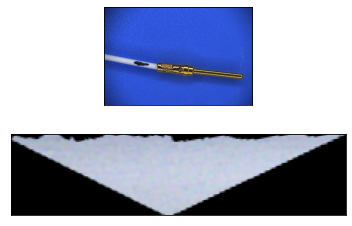

In [27]:
imgTongZiReadRoot = "/Users/zhouxinyu/Code/Python/jupyter/Project/ZF/数据测试/压线筒污染/数据2"
imgJYCReadRoot = "/Users/zhouxinyu/Code/Python/jupyter/Project/ZF/数据测试/绝缘层污染损伤/数据/污染2"

origin = cv2.imread(f'{imgJYCReadRoot}/{12}.jpg')
tongzi = getTongzi(origin)
showImages([origin, tongzi],["", ""], [2, 1], BGR=True)